# Introducing CNNs with TensorFlow


In this notebook, we're going to see how we can use ```TensorFlow``` to build convolutional neural networks to work with colour image data.

## Load libraries

In [1]:
# data tools
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# tf tools
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Activation, Flatten, Dense)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

2024-03-22 15:32:42.227395: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 15:32:42.231708: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 15:32:42.285212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 15:32:43.188586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


__Define plotting function__

In [2]:
def plot_history(H, epochs):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1) # plot 1
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2) # plot 2
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

__Load cifar10 data__

We first want to load the ```cifar-10``` dataset, normalize the values, and then binarize the labels.

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

**Question:** As an experiment, see what happens if you try to train the model with un-scaled images. Does it affect performance?

In [4]:
X_train = X_train/255
X_test = X_test/255

In [5]:
# Create one-hot encodings
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

We'll also manually create a list of labels for when we come to print the classification report later.

In [6]:
# Initialize label names for CIFAR-10 dataset
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

## ShallowNet 

We're going to begin by creating one of the simplest CNN architectures with only a single convolutional layer. This type of architecture is known as the ShallowNet architecture:
>INPUT => CONV => ReLU => FC

(only 1 convolutional layer, 1 activation layer, 1 fully connected layer)

In [7]:
# Initalise model (which is also a class)
model = Sequential()

# Define CONV => ReLU
model.add(Conv2D(32,                        # convolutional layer with 32 kernels
                (3,3),                      # each kernel is 3x3
                padding = "same",           # padding with zeroes
                input_shape = (32, 32, 3)))
model.add(Activation("sigmoid"))
           
# FC classifier
model.add(Flatten())                        # flatten into a single array
model.add(Dense(128))
model.add(Activation("sigmoid"))
model.add(Dense(10))                        # final layer with 10 outputs (multiclass classificaiton problem w 10 classes)
model.add(Activation("softmax"))

/home/ucloud/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


__Compile model__

We then compile our model using some of the same arguments we've already seen in different contexts.

In [8]:
sgd = SGD(learning_rate =.001)                      # learning rate = contrains how fast, the model can learn
model.compile(loss="categorical_crossentropy",      # loss function for multiclass classification problem
              optimizer = sgd,
              metrics=["accuracy"])                 # training the model to optimize on accuracy

__Model summary__

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,196,618 (16.01 MB)

 Trainable params: 4,196,618 (16.01 MB)

 Non-trainable params: 0 (0.00 B)

__Train model__

Finally, we train the model on the data and get our predictions.

In [9]:
H = model.fit(X_train, y_train,
              validation_split = 0.1,      # validate on 10% of the test data
              batch_size = 32,
              epochs = 20,                 # the model will see the training data 20 times
              verbose = 1)

Epoch 1/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.1097 - loss: 2.3090 - val_accuracy: 0.0992 - val_loss: 2.2913
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.1416 - loss: 2.2814 - val_accuracy: 0.1318 - val_loss: 2.2651
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.1759 - loss: 2.2556 - val_accuracy: 0.1968 - val_loss: 2.2303
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.2006 - loss: 2.2234 - val_accuracy: 0.2002 - val_loss: 2.1982
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.2217 - loss: 2.1914 - val_accuracy: 0.2124 - val_loss: 2.1676
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.2279 - loss: 2.1619 - val_accuracy: 0.2390 - val_loss: 2.1371
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.2457 - loss: 2.1315 - val_accuracy: 0.2272 - val_loss: 2.1118
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - accuracy: 0.2509 -

__Evaluate model__

In [10]:
predictions = model.predict(X_test, batch_size = 32)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [11]:
print(classification_report(y_test.argmax(axis = 1),
                            predictions.argmax(axis = 1),
                            target_names = label_names))

              precision    recall  f1-score   support

    airplane       0.40      0.52      0.45      1000
  automobile       0.37      0.36      0.37      1000
        bird       0.24      0.15      0.19      1000
         cat       0.22      0.13      0.16      1000
        deer       0.27      0.13      0.18      1000
         dog       0.33      0.32      0.33      1000
        frog       0.27      0.59      0.37      1000
       horse       0.37      0.24      0.29      1000
        ship       0.41      0.43      0.42      1000
       truck       0.39      0.43      0.41      1000

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.32     10000
weighted avg       0.33      0.33      0.32     10000



We can also use the ```plot_history()``` function available from ```TensorFlow``` to see how our model performs during training.

These plots can tell us *a lot* about whether a model is under- or over-fiting the data. You read more at [this fantastic blog post](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/). 

Other useful blogs are [here](https://rstudio-conf-2020.github.io/dl-keras-tf/notebooks/learning-curve-diagnostics.nb.html) and there's a good video overview [here](https://youtu.be/p3CcfIjycBA).

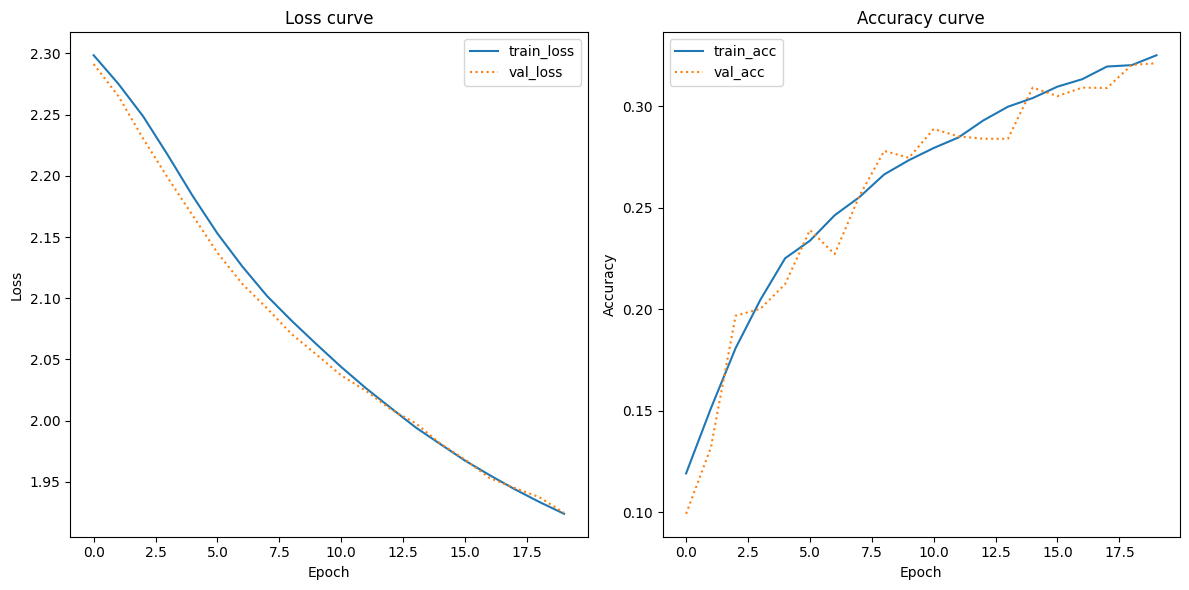

In [12]:
plot_history(H, 20)

## LeNet

Next, we'll look at a slightly more complicated CNN architecture, known as ```LeNet``` after its creator Yann LeCun, who is now Chief AI Scientist at Meta. You can read more [here](https://en.wikipedia.org/wiki/LeNet).
>INPUT => CONV => ReLU => MAXPOOL => CONV => ReLU => MAXPOOL => FC => ReLU => FC

__Define model__

In [16]:
# Define model
model = Sequential()

# First set of layers CONV => RELU => MAXPOOL
model.add(Conv2D(32, (3,3),
                 padding="same",
                 input_shape=(32,32,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2),
                       strides = (2,2)))    # one stride for moving horizontally and one for vertically

# Second set of layers CONV => RELU => MAXPOOL
model.add(Conv2D(50, (5,5),
                 padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2),
                       strides = (2,2)))

# FC => RELU
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))

# Softmax classifier
model.add(Dense(10))
model.add(Activation("softmax"))

/home/ucloud/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


__Compile model__

In [ ]:
sgd = SGD(learning_rate = 0.001)
model.compile(loss = "categorical_crossentropy",
              optimizer = sgd,
              metrics=["accuracy"])

__Model summary__

In [ ]:
model.summary()

__Train model__

In [ ]:
# Train model
H = model.fit(X_train, y_train,
              validation_split = 0.1, 
              batch_size = 32,
              epochs = 20,
              verbose = 1)

In [ ]:
plot_history(H,20)

In [ ]:
predictions = model.predict(X_test, batch_size = 32)
print(classification_report(y_test.argmax(axis = 1),
                            predictions.argmax(axis = 1),
                            target_names = label_names))

# Slightly more balanced model 

### Experiments

Before doing the experiments, the ShallowNet (with 20 epochs, 32 batch size, learning rate .001) returns an accuracy score of 47%.

1. Impact of normalizing the images
-   we tried to run the ShallowNet without normalizing the images. This resulted in worse accuracy (40%).
-   Also, the model overfits to a great extend and does not learn very well. When the train_loss decreases pr epoch, the validate_loss increases.
-   Shows how normalization is a very important pre-processing step. This could be because, that the data will not be in the "same range / format". Therefore, it will be more difficult for the model to learn during training.
- When the data is normalized, all the data will be in the range of 0 and 255. Therefore, the significant features in the data might "stand out more" and therefore, it will be easier for the model to learn them.

2. Learning rate (.01)
-   Way more prone to overfitting, as the model doesn't have time to learn!
-   Better accuracy 58% 

3. Change activation function from ReLU to Sigmoid
-   (ReLU is the most used avtivation function for NN and CNN)
-   Accuracy of 32%, so significantly worse than the "original" testing
-   The plot looks good and the model does not overfit (which is similar to the first)

= All in all, the original model is better!